Just a quick note about this project. If you are using google colab, please run the following code to get the other files uploaded properly into google colab. If not, you can skip this and head straight into the .zip file, which has this same file without this extra work at the top.

In [ ]:
!git clone https://github.com/shaiTroy/ML_Powerlifting_Project-Comp432.git 
%cd ML_Powerlifting_Project-Comp432

In [ ]:
import zipfile
import os
import shutil


zip_filename = "ML_Project-Comp432_ShaiTroy-40360052.zip"  
extract_folder = "ML_Project-Comp432_ShaiTroy-40360052"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

for item in os.listdir(extract_folder):
    s = os.path.join(extract_folder, item)
    d = os.path.join(os.getcwd(), item)
    if os.path.isdir(s):
        shutil.move(s, d)
    else:
        shutil.move(s, d)

os.rmdir(extract_folder)

# Machine Learning Powerlifting Project
Shai Troy, 40260053

### Project Proposal abstract:
An athlete's top priority is to be the best they can, compared to their peers.
But, for powerlifters, choosing a weight class to compete in brings differing
levels of competition. Knowing how much strength you will gain or lose when
moving weight classes is an extremely important part of the process, since
losing strength may prevent you from winning. So, what strength change can
athletes expect when gaining or losing weight? The goal of the project is to
look at how losing or gaining weight affects athletes' strength. I will be doing
this using data from openipf.org, which is a database for all previous
powerlifting competitions, with over 1.3 million powerlifting competition
performances. Since this is a regression problem, I foresee using MSE and
R-squared for the objective function and performance metrics. The main
challenge about this project is not knowing exactly what the data looks like. I
will want to create four models to see which one best represents the data:
ranging from simple and interpretable to complex and uninterpretable.

#### Project Proposal update
I will be using multiple models to try to find the most accurate score, using MAE and MSE. The models I initially only wanted to use were Linear Regression, Polynomial Regression, Feed-forward Neural Network and a Decision Tree. In addition to these, I will be implementing additional models including Random Forest, two gradient boosting algorithms called LightGBM and XGBoost-huber, and finally Tabnet (a type of transformer developed by google for tabular data). Finally, I discovered a massive problem with outliers, so I implemented an Unsupervised Learning Isolaion Forest model. I will go more in depth as I use each model.

## Imports:

To run the last model, this needs to be installed

In [ ]:
!pip install torch tqdm
!pip install pytorch-tabnet


While this one doesn't have to be installed, it is used in the project and should be installed if you want to run the optuna code blocks (hyperparameter testing blocks). Note that some of those blocks take multiple hours to test, so this is definitely not necessary.

In [ ]:
!pip install optuna
!pip install 'optuna-integration[pytorch_lightning]'

In [4]:
import csv
from datetime import datetime
import numpy as np
import time
import os
from sklearn.ensemble import IsolationForest, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sklearn.tree
import joblib
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetRegressor
import warnings
from multiprocessing import cpu_count, freeze_support
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from optuna.integration import PyTorchLightningPruningCallback


## Preprocessing

Preprocessing contains a bunch of different functions. In the first code block, I have three functions that deal with importing the data. Afterwards, I have the Isolation Forest model, which will be described when it is reached. I have a third code block that has a function to save the arrays to the file, and finally a fourth block to call all of the functions and let the code run.

In the first code block, I have three seperate functions:

#### ImportData:
- I import the data from the csv file, making sure I only get rows that are valid competitions. 
- In the IPF, there are different types of competitions, such as Bench Only, or Wraps, or even atheletes that are missing limbs. TO keep the data consistent, I ignore those types of competitions .
- I also ensure correct formatting of the variable names, making sure that later they can be used correctly.
- In a comment, I write the current order of the array that this function returns

#### SortData:
- First, I sort the competitions by date that they occurred, ensuring that the oldest competition is first, and the newest one is last
- Then, I sort the competitions by first and last name, making so that we can track the performance of a user's lifts between two competitions. 
- Because of these two operations, the competitions are now seperated by lifter, then by date.

#### UpdateDates
- I use a for loop to calculate the days between two competitions from the same lifter.
- I remove duplicate competitions (ones that occur on the same date with the same lifter)
- Finally, I remove lifters without an age variable or containing a missing attempt, to ensure all data has the same number of variables


In [ ]:
def importData():
    with open('openipf-2025-03-29-56319e49.csv', mode='r') as file:
        reader = csv.reader(file)
        data = []
        for row in reader:
            currentRow = []
            if row[2] != 'SBD' or row[3] != 'Raw' or row[7] == 'Special Olympics' or row[30] == '' or row[0] == '' or row[36] == '': continue
            if row[7] == 'Juniors': row[7] = 'Junior'
            if row[7] == 'Sub-Juniors': row[7] = 'Sub-Junior'
            for i in [0, 1, 8, 25, 36, 4, 5, 6, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 24, 30]:
                    currentRow.append(row[i])
            data.append(currentRow)
        return data
    #row format:
    # [0] = Name
    # [1] = Sex
    # [2] = BodyWeight
    # [3] = Total
    # [4] = Date
    # [5] = Age
    # [6] = AgeClass
    # [7] = BirthYear
    # [8] = Squat1
    # [9] = Squat2
    # [10] = Squat3
    # [11] = Best Squat
    # [12] = Bench1
    # [13] = Bench2
    # [14] = Bench3
    # [15] = Best Bench
    # [16] = Deadlift1
    # [17] = Deadlift2
    # [18] = Deadlift3
    # [19] = Best Deadlift
    # [20] = GL
    
def sortData(data):
    # Sort by date at index 4
    data.sort(key=lambda x: datetime.strptime(x[4], '%Y-%m-%d'))
    # Sort by first and last name at index 0
    data.sort(key=lambda x: (x[0].split()[0], x[0].split()[1]) if len(x[0].split()) > 1 else (x[0].split()[0], ''))
    return data

def updateDates(filtered):
    first_occurrence_date = None
    current_name = None

    for entry in filtered:
        name = entry[0]
        date_str = entry[4]

        try:
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except ValueError:
            print(f"Skipping entry due to incorrect date format: {date_str}")
            continue
        
        if name != current_name:
            current_name = name
            first_occurrence_date = date_obj
            entry[4] = 0
        else:
            days_difference = (date_obj - first_occurrence_date).days
            entry[4] = days_difference
    i = 0
    n = len(filtered)
    while i < len(filtered)-1:
        if filtered[i][4] == filtered[i+1][4]:
            filtered.pop(i)
        else:
            i += 1 
    if filtered[-1][4] == 0:
        filtered.pop(-1)
    print(f"Filtered out {n - len(filtered)} entries with the same lifter and date, {len(filtered)} entries remaining.")
    
    #filter out entries with no age or incorrect attempts
    i = 0
    n = len(filtered)
    while i < len(filtered)-1:
        try:
            filtered[i][5] = float(filtered[i][5])
        except:
            try: 
                filtered[i][5] = float(filtered[i][6][:2])
            except:
                try:
                    filtered[i][5] = float(filtered[i][7][:2])
                except:
                    filtered.pop(i)
                    continue
        for j in range(8, 21):
            try:
                filtered[i][j] = float(filtered[i][j])
            except:
                filtered.pop(i)
                i -= 1
                break
            if filtered[i][j] == 0:
                print(f"Found 0 attempt in {filtered[i]}")
                filtered.pop(i)
                i -= 1
                break
        i += 1
        
    print(f"Filtered out {n - len(filtered)} entries with no age or incorrect attempts, {len(filtered)} entries remaining.")
    return filtered

### Isolation Forest

Isolation Forest is an unsupervised learning algorithm used for finding outliers in data. In this particular instance, I determined that outliers should only be determined by the change in total, as in what my models will try to find. The reason behind this is that lifters could have abnormally bad or abnormally good performances, which don't really benefit my models. These bad conmpetitions can occur, but most of the time that they do occur it is because of an injury. 

For example, a lifter could be hurt in their first ever competition and put up a 300kg total. But, on their second competition, when they are no longer hurt, they put up a 600kg total. Should this change of 300kg be used to find what normal lifters can expect in their competitions? I believe not. 

The Isolation Forest algorithm determioned 83.11% of the data to not be outliers. This can be interpretted as follows: Of lifters with at least two competitions, 16.89% of the time one of their competitions is the result of an injury. Since injuries are fairly frequent, and there is no data point in the csv to otherwise determine injury, this is what I will be using.

Isolation Forest works like so: 
- Similar to a random forest model, it is a collection of a predetermined number of trees.
- Each tree randomly splits along one of the features (in this case, only one feature), and creates a random boundary.
- After a predetermined number of splits, it determines the chance that the point will be an anomoly, by comparing to where most of the points are. 
- After the process is done, it averages the anomoly scores.
- Anything at or above 0 is determined to not be an anomoly, while anything below is

As for the code below, we pass the data to the algorithm, and remove anything that it deems to be an anomoly. While on the gragh it looks like most of the data, there is over 80% that is not found to be anomolous.




In [ ]:
def Iso(arr):
    arr = np.array(arr)

    Input = np.delete(arr, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], axis=1)
    Input = StandardScaler().fit_transform(Input) 

    model = IsolationForest(n_estimators=200, max_samples=256, random_state=42)
    model.fit(Input)

    scores = model.decision_function(Input)
    outliers = np.sum(scores <= 0)  # Count outliers
    total_points = len(scores)  # Total number of samples

    outlier_percentage = ((total_points - outliers) / total_points) * 100
    print(f"Outlier Percentage: {outlier_percentage:.2f}%, number of remaining points: {total_points - outliers}")
    
    mask = scores >= 0

    filtered_arr = arr[mask]
    
    input = np.array((filtered_arr[:, :-1]))
    out = np.array(filtered_arr[:, -1])
    
    levels = 0  
    
    plt.figure(figsize=(8, 6))
    plt.tricontour(arr[:, 3], arr[:, 20], scores, levels=levels, colors='black', linewidths=2, linestyles='dashed')
    plt.scatter(arr[:, 3], arr[:, 20], c=scores, cmap='coolwarm', s=100)
    plt.xlabel("Init Total")
    plt.ylabel("Change in Total")
    plt.title('Anomaly Scores for Outlier Detection')
    plt.xlim(0, 1200)
    plt.ylim(-600, 600)
    
    plt.show()
  
    return input, out

### End Of Preprocessing
Here, I take the arrays and perform the following operations:
- change the gender input to numerical format (0 for F, 1 for M)
- add in the change of weight between two subsequent competitions
- add in the change in total between two subsequent competitions
- call the Isolation Forest method created above
- seperate the data into train and testing splits, and save them for future use

Finally, we call all the above functions to preprocess the data

In [ ]:
def transform_and_save_arrays(filtered):
    comps = []
    cur_name = None
    holder = []

    for row in filtered:
        if cur_name != row[0]:
            cur_name = row[0]
            holder = [1, row[1], float(row[2]), float(row[3]), float(row[4]), row[5], float(row[8]), float(row[9]), float(row[10]), float(row[11]), float(row[12]), float(row[13]), float(row[14]), float(row[15]), float(row[16]), float(row[17]), float(row[18]), float(row[19]), row[20]]
        else:
            if holder[1] == 'M':
                holder[1] = 1
            else:
                holder[1] = 0
            holder[4] = row[4] - holder[4]
            holder.append(float(row[2])-holder[2])
            holder.append(float(row[3])-holder[3])
            comps.append(holder)
            holder = [1, row[1], float(row[2]), float(row[3]), float(row[4]), row[5], float(row[8]), float(row[9]), float(row[10]), float(row[11]), float(row[12]), float(row[13]), float(row[14]), float(row[15]), float(row[16]), float(row[17]), float(row[18]), float(row[19]), row[20]]
    
    print(f"Number of entries: {len(comps)}")

    #Send to unsupervised algo to learn injured vs healthy
    Inputs, Outputs = Iso(comps)
    
    #Array looks as following:
    
    #Inputs
    #[0] = 1 (bias)
    #[1] = Sex (0 for F, 1 for M)
    #[2] = Init Weight
    #[3] = Init Total
    #[4] = Days between competitions
    #[5] = Age
    #[6] = Squat1
    #[7] = Squat2
    #[8] = Squat3
    #[9] = Best Squat
    #[10] = Bench1
    #[11] = Bench2
    #[12] = Bench3
    #[13] = Best Bench
    #[14] = Deadlift1
    #[15] = Deadlift2
    #[16] = Deadlift3
    #[17] = Best Deadlift
    #[18] = GL
    #[19] = Change Weight

    
    #Outputs
    #[0] = Change Total

    #split up the data into training and testing splits
    np.random.shuffle(Inputs)
    np.random.shuffle(Outputs)
    
    Inputs_Train = Inputs[:int(len(Inputs)*0.8)]
    Outputs_Train = Outputs[:int(len(Outputs)*0.8)]
    Inputs_Test = Inputs[int(len(Inputs)*0.8):]
    Outputs_Test = Outputs[int(len(Outputs)*0.8):]
    
    print(f"Number of training samples: {len(Inputs_Train)} number of test samples: {len(Inputs_Test)}")

    # Save the arrays to files
    np.save('Inputs_Train.npy', Inputs_Train)
    np.save('Outputs_Train.npy', Outputs_Train)
    np.save('Inputs_Test.npy', Inputs_Test)
    np.save('Outputs_Test.npy', Outputs_Test)

Filtered out 121901 entries with the same lifter and date, 371624 entries remaining.
Filtered out 121289 entries with no age or incorrect attempts, 250335 entries remaining.
Number of entries: 179901
Outlier Percentage: 83.11%, number of remaining points: 149510


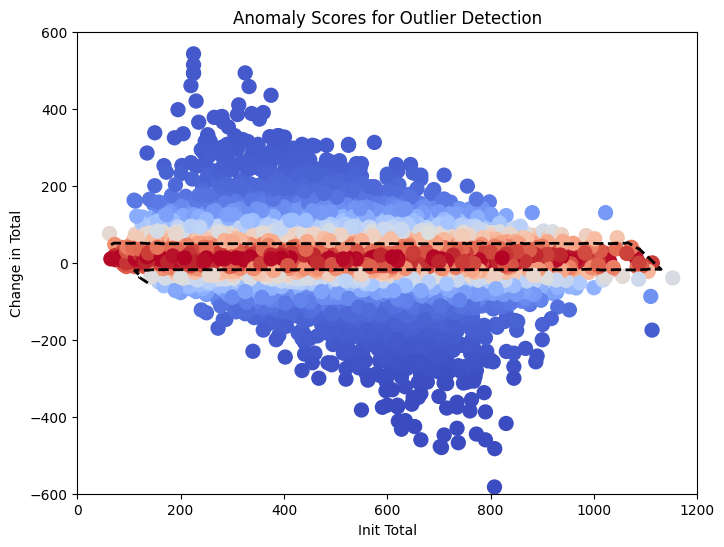

Number of training samples: 119608 number of test samples: 29902
Data has been preprocessed and saved to files.


In [ ]:
transform_and_save_arrays(updateDates(sortData(importData())))
print("Data has been preprocessed and saved to files.")

It is sometims usefull to see how the data correlates with itself. In the following code block, I print it to a plot.

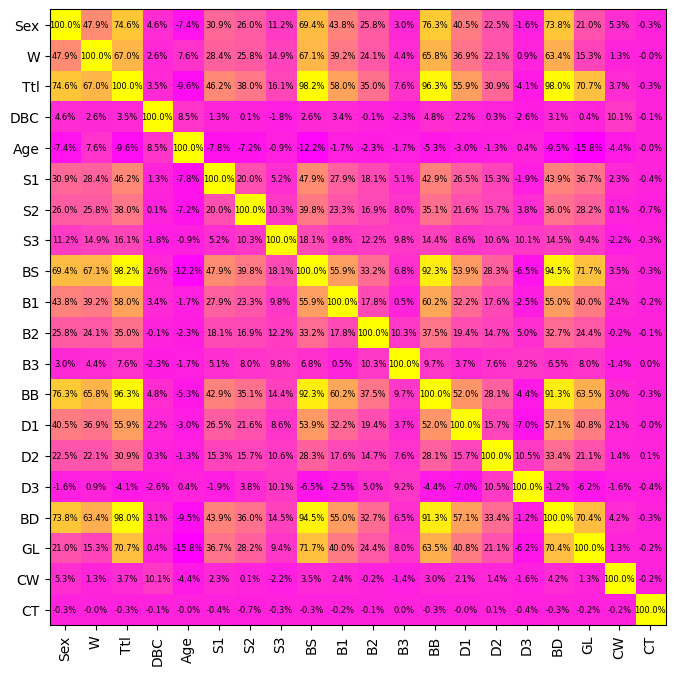

In [ ]:
def calculate_corrcoef(data):
    n = data.shape[1]
    corrcoef_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            corrcoef_matrix[i, j] = np.corrcoef(data[:, i], data[:, j])[0, 1]
            corrcoef_matrix[j, i] = corrcoef_matrix[i, j]
    return corrcoef_matrix

Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)
names = ['Sex', 'W', 'Ttl', 'DBC', 'Age', 'S1', 'S2', 'S3', 'BS', 'B1', 'B2', 'B3', 'BB', 'D1', 'D2', 'D3', 'BD', 'GL', 'CW', 'CT']
Outputs_Train = Outputs_Train.reshape(-1, 1)  # Convert to a 2D array with one column
Outputs_Test = Outputs_Test.reshape(-1, 1)  # Convert to a 2D array with one column

combined_data = np.concatenate((Inputs_Train[:, 1:], Outputs_Train), axis=1)
coef = calculate_corrcoef(combined_data)

plt.figure(figsize=(20, 8))
plt.imshow(coef, cmap='spring', interpolation='nearest')  

for i in range(len(names)):
    for j in range(len(names)):
        plt.text(j, i, f'{coef[i, j]*100:.1f}%', ha='center', va='center', color='black', fontsize=6)

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.show()

## Linear Regression
Here, I simply use the direct solution to find the best MSE and L1 scores.

MSE: 242.1831, L1: 12.7659

MSE: 242.1831, L1: 12.7659


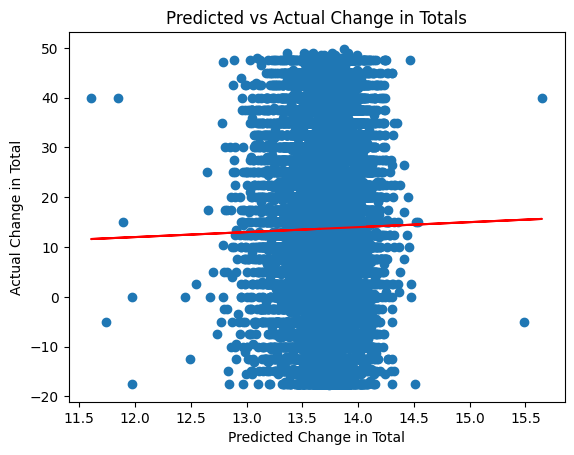

In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

# Linear model with direct solution:
W = np.linalg.inv(Inputs_Train.T @ Inputs_Train) @ Inputs_Train.T @ Outputs_Train

MSE = np.mean((Outputs_Test - Inputs_Test @ W)**2)
L1 = np.mean(np.abs(Outputs_Test - Inputs_Test @ W))
print(f"MSE: {MSE:.4f}, L1: {L1:.4f}")

plt.plot(Inputs_Test @ W, Outputs_Test, 'o')
plt.plot(Inputs_Test @ W, Inputs_Test @ W, 'r')  
plt.xlabel('Predicted Change in Total')
plt.ylabel('Actual Change in Total')
plt.title('Predicted vs Actual Change in Totals')
plt.show()

## Polynomial Regression
Here, we have three different code blocks.

The first one is to load the training and test data, as well as importing the polynomial and linear regression models from sklearn.

The second is used to find the right degree number. After a little bit of training, we find that degree 1 is the best, which is essentially just normal linear regression.

The third is used to actually train the model and see its perfromance on the test data, as well as plot its output. We can see that it is identical to linear regression, since it is to the first degree.

MSE: 242.2111, L1: 12.7669


In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

# Take 15% of the data for validation
Inputs_Validation = Inputs_Train[int(len(Inputs_Train)*0.85):]
Outputs_Validation = Outputs_Train[int(len(Outputs_Train)*0.85):]
Inputs_Train = Inputs_Train[:int(len(Inputs_Train)*0.85)]
Outputs_Train = Outputs_Train[:int(len(Outputs_Train)*0.85)]
print(f"Number of training samples: {len(Inputs_Train)}")
print(f"number of validation samples: {len(Inputs_Validation)}")
print(f"number of test samples: {len(Inputs_Test)}")

Number of training samples: 101666
number of validation samples: 17942
number of test samples: 29902


In [ ]:
# Find the best Degree
degrees = range(1, 4)  # Test degrees from 1 to 3

for d in degrees:
    startTime = time.time()
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(Inputs_Train)
    X_val_poly = poly.transform(Inputs_Validation)
    
    model = LinearRegression()
    model.fit(X_train_poly, Outputs_Train)
    
    predictions = model.predict(X_val_poly)
    MSE = mean_squared_error(Outputs_Validation, predictions)
    L1 = np.mean(np.abs(Outputs_Validation - predictions))
    
    print(f"Degree {d}, MSE: {MSE:.4f}, L1: {L1:.4f} in {time.time() - startTime:.2f} seconds")

Degree 1, MSE: 235.0052, L1: 12.5482 in 0.09 seconds
Degree 2, MSE: 235.3451, L1: 12.5553 in 1.24 seconds
Degree 3, MSE: 98545.8645, L1: 17.3387 in 16.34 seconds


Degree 1, MSE: 242.2111, L1: 12.7669


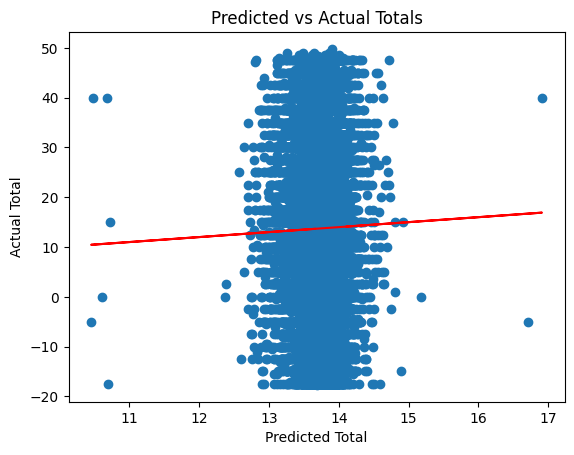

In [ ]:
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(Inputs_Train)
X_val_test = poly.transform(Inputs_Test)

model = LinearRegression()
model.fit(X_train_poly, Outputs_Train)

predictions = model.predict(X_val_test)
MSE = mean_squared_error(Outputs_Test, predictions)
L1 = np.mean(np.abs(Outputs_Test - predictions))

print(f"Degree {1}, MSE: {MSE:.4f}, L1: {L1:.4f}")

plt.plot(predictions, Outputs_Test, 'o')
plt.plot(predictions, predictions, 'r')
plt.xlabel('Predicted Total')
plt.ylabel('Actual Total')
plt.title('Predicted vs Actual Totals')
plt.show()

## Feed-Forward Neural Network

For this project, I have created two Neural Network models. The first one uses Pytorch, with a predefined number of layers and nodes in each layer, aswell as relu activation and batch normalization. The second one again uses pytorch, but instead tries to find the ideal number of layers and nodes in each layer, as well as the ideal activation function. Both of these models are passed throught hyperparameter testing, which finds the ideal batch size, num of epochs, learning rate, and weight decay. Finally, I test the best version of those models and reveal the best MSE and MAE from these models.

### Standardize
Standardizes the data, and storing mean for future use

In [7]:
class Standard:
    def __init__(self, Input_Train, Inputs_Test, Inputs_Validation=None):
        self.setNormalizer(Input_Train)
        if Inputs_Validation is None:
            self.normalize(Input_Train, Inputs_Test)
        else: self.normalize_w_valid(Input_Train, Inputs_Test, Inputs_Validation)
        
    def setNormalizer(self, x):
        self.mean = np.mean(x, axis=0, keepdims=True)
        self.std = np.std(x, axis=0, keepdims=True)
        self.std[self.std == 0] = 1

    def normalize_w_valid(self, Inputs_Train, Inputs_Test, Inputs_Validation):
        self.Inputs_Train = (Inputs_Train - self.mean) / self.std
        self.Inputs_Test = (Inputs_Test - self.mean) / self.std 
        self.Inputs_Validation = (Inputs_Validation - self.mean) / self.std
    
    def normalize(self, Inputs_Train, Inputs_Test):
        self.Inputs_Train = (Inputs_Train - self.mean) / self.std
        self.Inputs_Test = (Inputs_Test - self.mean) / self.std 


### NN Model 1
The first model will be made using Pytorch, with a specific number of layers and nodes in each layer. While I did do some testing to find out what might work, we will later explore other options that provide conclusive evidence to the number of layers and nodes in a layer required for this model to work the most efficiently. 

In Pytorch, you can use your GPU. So, we want to do most computations on the gpu, and I will be specificying the device below. Cuda for Google Colab, MPS for my macbook m2 gpu, and cpu otherwise. We will load the data, then create the NN model with 5 layers [256, 128, 64, 32, 1 nodes each]. I will then provide a training function, which will be used to train the final model and test it. Then, I will use Optuna to perform a search to find the best hyperparameters for this model, specifically batch size, learning rate and number of epochs. Finally, I will take the best performing model and test it.

L1: 12.6679, MSE: 240.1136

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

#load the data
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

Outputs_Train = Outputs_Train.reshape(-1, 1)
Outputs_Test = Outputs_Test.reshape(-1, 1)

# Take 15% of the data for validation
Inputs_Validation = torch.tensor(Inputs_Train[int(len(Inputs_Train)*0.9):], dtype=torch.float32).to(device)
Outputs_Validation = torch.tensor(Outputs_Train[int(len(Outputs_Train)*0.9):], dtype=torch.float32).to(device)
Inputs_Train = torch.tensor(Inputs_Train[:int(len(Inputs_Train)*0.9)], dtype=torch.float32).to(device)
Outputs_Train = torch.tensor(Outputs_Train[:int(len(Outputs_Train)*0.9)], dtype=torch.float32).to(device)
Inputs_Test = torch.tensor(Inputs_Test, dtype=torch.float32).to(device)
Outputs_Test = torch.tensor(Outputs_Test, dtype=torch.float32).to(device)

standardized = Standard(Inputs_Train.cpu().numpy(), Inputs_Test.cpu().numpy(), Inputs_Validation.cpu().numpy())
Inputs_Train = torch.tensor(standardized.Inputs_Train, dtype=torch.float32).to(device)
Inputs_Test = torch.tensor(standardized.Inputs_Test, dtype=torch.float32).to(device)
Inputs_Validation = torch.tensor(standardized.Inputs_Validation, dtype=torch.float32).to(device)

In [ ]:
class roundLinear(torch.nn.Module):
    def __init__(self):
        super(roundLinear, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(20, 256, bias=False),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(256, 128, bias=False),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(128, 64, bias=False),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            
            torch.nn.Linear(64, 32, bias=False),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            
            torch.nn.Linear(32, 1, bias=False)
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
loss = torch.nn.L1Loss()

def shuffle_data():
    global Inputs_Train, Outputs_Train  
    indices = torch.randperm(len(Inputs_Train)).cpu()
    Inputs_Train = Inputs_Train.cpu()[indices].to(device)
    Outputs_Train = Outputs_Train.cpu()[indices].to(device)

def train(model, optimizer, batch_size, max_epoch):
    start_time = time.time()
    model.train()
    curloss = []
    prev = None
    for i in range(0, max_epoch):
        shuffle_data()        
        for j in range(0, len(Inputs_Train), batch_size):
            X = Inputs_Train[j:j+batch_size]
            y = Outputs_Train[j:j+batch_size]
            
            y_pred = model(X)

            l = loss(y_pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            curloss.append(l.item())
        avrg = sum(curloss) / len(curloss)
        print(f"Epoch {i} completed, loss: {avrg:.4f}")
        curloss = []
        if prev is not None and avrg >= prev + 0.0001:
            #stops early if the loss is getting worse
            break
        prev = avrg
    #test on validation set
    model.eval()
    y_pred = model(Inputs_Validation)
    l = loss(y_pred, Outputs_Validation)
    elapsed_time = time.time() - start_time
    print(f"Validation Loss: {l:.2f}, time: {elapsed_time:.2f} seconds, epoch: {i}, batch size: {batch_size}, learning rate: {optimizer.defaults['lr']}, optimizer type: {optimizer.__class__.__name__}, decay: {optimizer.defaults['weight_decay']}")


Please skip this block, I provide the output in a markdown below. You can reduce the number of trials just to see if it works, but it takes way too long to actually run on any system

In [ ]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)
    num_epochs = trial.suggest_int("num_epochs", 75, 150, step=25)
    model = roundLinear().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Num Epochs: {num_epochs}")
    model.train()
    for epoch in range(num_epochs):
        shuffle_data()
        for j in range(0, len(Inputs_Train), batch_size):
            X = Inputs_Train[j:j+batch_size]
            y = Outputs_Train[j:j+batch_size]
            
            y_pred = model(X)
            l = loss(y_pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(Inputs_Validation)
        val_loss = loss(y_pred, Outputs_Validation).item()
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)
print("Top 5 trials:")
top_trials = sorted(study.trials, key=lambda t: t.value)[:5]
for i, trial in enumerate(top_trials):
    print(f"Rank {i+1}:")
    print(f"  Batch Size: {trial.params['batch_size']}")
    print(f"  Learning Rate: {trial.params['learning_rate']}")
    print(f"  Num Epochs: {trial.params['num_epochs']}")
    print(f"  Validation Loss: {trial.value}")

After 2339 minutes, or 1 Day and 15 Hours:

Top 5 trials:

Rank 1:
  - Batch Size: 16
  - Learning Rate: 0.008859999037340834
  - Num Epochs: 150
  - Validation Loss: 12.813685417175293

Rank 2:
  - Batch Size: 16
  - Learning Rate: 0.009245163020429659
  - Num Epochs: 150
  - Validation Loss: 12.813837051391602

Rank 3:
  - Batch Size: 16
  - Learning Rate: 0.00965106769893062
  - Num Epochs: 125
  - Validation Loss: 12.81710147857666

Rank 4:
  - Batch Size: 16
  - Learning Rate: 0.006944482120140382
  - Num Epochs: 125
  - Validation Loss: 12.818496704101562

Rank 5:
  - Batch Size: 16
  - Learning Rate: 0.009999109807517018
  - Num Epochs: 125
  - Validation Loss: 12.819931030273438

So, I will be using the best ranked model below and saving it to a file:

In [ ]:
model = roundLinear().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.008859999037340834, weight_decay=0.0001)

print(f"Training on {Inputs_Train.size(0)} entries")

batch_size = 16
print(f"Batch size: {batch_size}")

model_filename = "FNN_model1.pth"
if os.path.exists(model_filename):
    torch.serialization.add_safe_globals([roundLinear, set, torch.nn.modules.container.Sequential, torch.nn.modules.linear.Linear, torch.nn.ReLU, torch.nn.BatchNorm1d, torch.nn.Dropout])
    print("Loading existing model...")
    model = torch.load(model_filename, weights_only=True, map_location=torch.device("cpu"))
else:
    train(model, optimizer, batch_size, 150)
    torch.save(model, model_filename)
    print("Model saved.")

model.eval()
y_pred = model(Inputs_Test)
l = loss(y_pred, Outputs_Test)
mse = mean_squared_error(Outputs_Test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
print(f"L1: {l:.4f}, MSE: {mse:.4f}")

Training on 107647 entries
Batch size: 16
Loading existing model...
L1: 12.6679, MSE: 240.1136


### NN Model 2

While the previous model is pretty good, it isn't perfect. I want to use pytorch to create different structures of neural networks, and train them using optuna to find both the best structure and the best set of hyperparameters. 

First I import the variables from scratch. I also want to remove the bias, since it is easier to no have to add in that parameter every time. Then we test for the best number of layers, nodes in each layer (enforcing a decreasing order), activation function, alpha, batch size, and learning rate.

L1: 12.6358, MSE: 241.1973

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

Inputs_Train = np.load('Inputs_Train.npy').astype(float)[:, 1:]
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)[:, 1:]
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

val_split = int(len(Inputs_Train) * 0.8)
Inputs_Validation = torch.tensor(Inputs_Train[val_split:], dtype=torch.float32)
Outputs_Validation = torch.tensor(Outputs_Train[val_split:], dtype=torch.float32)
Inputs_Train = torch.tensor(Inputs_Train[:val_split], dtype=torch.float32)
Outputs_Train = torch.tensor(Outputs_Train[:val_split], dtype=torch.float32)

standardized = Standard(Inputs_Train.numpy(), Inputs_Test, Inputs_Validation.numpy())
Inputs_Train = torch.tensor(standardized.Inputs_Train, dtype=torch.float32)
Inputs_Test = torch.tensor(standardized.Inputs_Test, dtype=torch.float32)
Inputs_Validation = torch.tensor(standardized.Inputs_Validation, dtype=torch.float32)

mid_idx = len(Inputs_Validation) // 2
Inputs_Val_1 = Inputs_Validation[:mid_idx]
Outputs_Val_1 = Outputs_Validation[:mid_idx]
Inputs_Val_2 = Inputs_Validation[mid_idx:]
Outputs_Val_2 = Outputs_Validation[mid_idx:]

Inputs_Train = Inputs_Train.to(device)
Inputs_Val_1 = Inputs_Val_1.to(device)
Inputs_Val_2 = Inputs_Val_2.to(device)
Outputs_Train = Outputs_Train.to(device)
Outputs_Val_1 = Outputs_Val_1.to(device)
Outputs_Val_2 = Outputs_Val_2.to(device)

print(f"Training on {Inputs_Train.shape} entries")
print(f"Validation on {Inputs_Validation.shape} entries, separated into {Inputs_Val_1.shape} and {Inputs_Val_2.shape}")
print(f"Testing on {Inputs_Test.shape} entries")


Training on torch.Size([95686, 19]) entries
Validation on torch.Size([23922, 19]) entries, separated into torch.Size([11961, 19]) and torch.Size([11961, 19])
Testing on torch.Size([29902, 19]) entries


In [22]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, layers, activation, use_batchnorm=False, dropout=0.0):
        super().__init__()
        activ = {
            "relu": torch.nn.ReLU(),
            "tanh": torch.nn.Tanh(),
            "logistic": torch.nn.Sigmoid()
        }[activation]

        net = []
        prev = input_dim
        for l in layers:
            net.append(torch.nn.Linear(prev, l))
            if use_batchnorm:
                net.append(torch.nn.BatchNorm1d(l))
            net.append(activ)
            if dropout > 0:
                net.append(torch.nn.Dropout(dropout))
            prev = l
        net.append(torch.nn.Linear(prev, 1))
        self.model = torch.nn.Sequential(*net)

    def forward(self, x):
        return self.model(x)


In [23]:
study_dir = os.path.join('/Users/shaitroy/Docs/ipf_data/openipf-2025-03-29', 'optuna_studies')
os.makedirs(study_dir, exist_ok=True)
storage_path = f'sqlite:///{study_dir}/mlp_study.db'

In [24]:
sampler = optuna.samplers.TPESampler(n_startup_trials=30)  # You can increase this number
study = optuna.create_study(
    direction="minimize",
    storage=storage_path,
    study_name="nn6_study",
    sampler=sampler,
    load_if_exists=True
)

[I 2025-04-10 01:25:57,380] A new study created in RDB with name: nn6_study


In [ ]:
study = optuna.load_study(
    study_name="nn6_study",
    storage=storage_path,
)

Again, please don't run this code block. It will take many hours to complete, so just read the output below. If you really want to run it, reduce the number of trials.

The idea behind the custom loss function is to enforce regularization. I had a problem previously where the model massively overfit to the validation data, so I seperated it into two groups and enforced that the custom loss is mse of the first one plus the difference between the two mse to a factor. That way, if a model is more than 0.1 off, it makes the mse a lot worse, while if it's less than 0.1 off, it makes the mse a lot better.

In [25]:
def custom_loss(y_true1, y_pred1, y_true2, y_pred2):
    mse1 = mean_absolute_error(y_true1, y_pred1)
    mse2 = mean_absolute_error(y_true2, y_pred2)
    return (mse1 + (np.square(5 * (mse1 - mse2))/5))
    #This function is required for proper regularization

In [ ]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 2, 10)
    max_nodes = trial.suggest_int("max_nodes", 32, 512, step=32)

    step_sizes = [max_nodes - i * ((max_nodes-32) // (n_layers - 1)) for i in range(n_layers)]
    layers = [int(round(n / 32) * 32) for n in step_sizes]
    layers = [max(32, min(max_nodes, l)) for l in layers]

    learning_rate = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512, 1024, 2048])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    patience = trial.suggest_int("patience", 3, 10)  
    dropout = trial.suggest_float("dropout", 0.0, 0.5)  
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])  

    model = MLP(
        input_dim=Inputs_Train.shape[1],
        layers=layers,
        activation=activation,
        use_batchnorm=use_batchnorm,  
        dropout=dropout              
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    criterion = torch.nn.L1Loss()

    # Early stopping parameters
    best_loss = float('inf')
    counter = 0
    
    train_dataset = TensorDataset(Inputs_Train, Outputs_Train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    print("Trial starting training with parameters:")
    print(f"Layers: {layers}, Learning Rate: {learning_rate}, Alpha: {alpha}, Batch Size: {batch_size}, Activation: {activation}, Dropout: {dropout}, Use BatchNorm: {use_batchnorm}, Patience: {patience}")


    for epoch in range(150):

        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            
            yb = yb.view(-1, 1)  # Ensure the target has the same shape as the output


            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if running_loss < best_loss:
            best_loss = running_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Validation after training ends
    model.eval()
    y_pred1 = model(Inputs_Val_1.to(device))
    y_pred2 = model(Inputs_Val_2.to(device))
    final_loss = custom_loss(Outputs_Val_1.cpu().detach().numpy(), y_pred1.cpu().detach().numpy(), Outputs_Val_2.cpu().detach().numpy(), y_pred2.cpu().detach().numpy())
    

    return final_loss

study.optimize(objective, n_trials=250)

In [ ]:
valid_trials = [t for t in study.trials if t.value is not None]

top_trials = sorted(valid_trials, key=lambda t: t.value)[:5]

def compute_layers(n_layers, max_nodes):
    step_sizes = [max_nodes - i * ((max_nodes - 32) // (n_layers - 1)) for i in range(n_layers)]
    layers = [int(round(n / 32) * 32) for n in step_sizes]
    return [max(32, min(max_nodes, l)) for l in layers]

for i, trial in enumerate(top_trials):
    print(f"Rank {i+1}: Trial #{trial.number}")
    print(f"  Validation Loss: {trial.value}")
    n_layers = trial.params.get('n_layers')
    max_nodes = trial.params.get('max_nodes')
    if n_layers is not None and max_nodes is not None:
        layers = compute_layers(n_layers, max_nodes)
        print(f"  Layers: {layers}")
    print(f"  learning_rate_init: {trial.params.get('learning_rate_init', 'N/A')}")
    print(f"  alpha: {trial.params.get('alpha', 'N/A')}")
    print(f"  batch_size: {trial.params.get('batch_size', 'N/A')}")
    print(f"  activation: {trial.params.get('activation', 'N/A')}")
    print(f"  dropout: {trial.params.get('dropout', 'N/A')}")
    print(f"  use_batchnorm: {trial.params.get('use_batchnorm', 'N/A')}")
    print(f"  patience: {trial.params.get('patience', 'N/A')}")
    print()

Rank 1: Trial #257
  Validation Loss: 12.79738807265403
  Layers: [320, 32]
  learning_rate_init: 0.003218921923908175
  alpha: 2.282081399704522e-06
  batch_size: 256
  activation: relu
  dropout: 0.47268936245910603
  use_batchnorm: False
  patience: 7
  optimizer: N/A

Rank 2: Trial #139
  Validation Loss: 12.79760092309516
  Layers: [288, 32]
  learning_rate_init: 0.0019307724742767876
  alpha: 1.2506416797681418e-06
  batch_size: 64
  activation: relu
  dropout: 0.473020019972953
  use_batchnorm: False
  patience: 7
  optimizer: N/A

Rank 3: Trial #220
  Validation Loss: 12.800147027897765
  Layers: [256, 32]
  learning_rate_init: 0.0025750596061675157
  alpha: 3.153880719826149e-06
  batch_size: 256
  activation: relu
  dropout: 0.49978166656445927
  use_batchnorm: False
  patience: 7
  optimizer: N/A

Rank 4: Trial #208
  Validation Loss: 12.80267359759182
  Layers: [288, 32]
  learning_rate_init: 0.003584698570796142
  alpha: 2.8095928746521776e-06
  batch_size: 256
  activatio

Originally, I had a problem with overfitting. So, that's why I have a second hyperparameter testing group, for regularization. Now, we run the best model, and test its performance

In [40]:
model = MLP(
    input_dim=Inputs_Train.shape[1],
    layers=[320, 32],
    activation='relu',
    use_batchnorm=False,  
    dropout=0.47268936245910603              
).to(device)

patience = 7

optimizer = torch.optim.Adam(model.parameters(), lr=0.003218921923908175, weight_decay=2.282081399704522e-06)
criterion = torch.nn.L1Loss()

best_loss = float('inf')
counter = 0

train_dataset = TensorDataset(Inputs_Train, Outputs_Train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(150):

    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        
        yb = yb.view(-1, 1)  # Ensure the target has the same shape as the output


        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if running_loss < best_loss:
        best_loss = running_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.eval()
y_pred = model(Inputs_Test.to(device)).cpu().detach().numpy()

    
mae = mean_absolute_error(Outputs_Test, y_pred)
mse = mean_squared_error(Outputs_Test, y_pred)
print(f"L1: {mae:.4f}, MSE: {mse:.4f}")

Early stopping at epoch 35
L1: 12.6358, MSE: 241.1973


## Decision Tree
The Decision Tree model is also used to try to see the best MSE and MAE for this problem. 

In the first code block, I simply import the needed sklearn functions and bring the data from the file.

The second code block is used to figure out the best depth. I would reccomend skipping this block, since it is randomly testing 500 different max depths and min number of leaf samples. I use RandomizedSearchCV to find what might be the best outcome in the shortest amount of time, since testing using a gridsearch algorithm could (and has) taken a lot more time then a random search, while only yeilding slightly better results. 

The third code block is used to skip the second, so that it can train a model on what I have already deemed the best hyperparameters.

The fourth code block is there to fit the data to the decision tree, and calculate our metrics, and finally

the fifth code block outputs what decisions took place at every level.

MSE: 239.7196, L1: 12.6897

In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float).ravel()
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)
print(f"Training on {Inputs_Train.shape[0]} entries")

Training on 119608 entries


Again, skip the following code block if you do not want to wait through hyperparameter testing

In [ ]:
model = DecisionTreeRegressor()
param_grid = {'max_depth': range(1, 25),
              'min_samples_leaf': [1, 100, 1000, 5000, 10000]
              }
grid_search = RandomizedSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, n_iter=100)
grid_search.fit(Inputs_Train, Outputs_Train)

results = grid_search.cv_results_
sorted_indices = np.argsort(results['mean_test_score'])[::-1]  # Sort in descending order
top_5_indices = sorted_indices[:5]

print("\nTop 5 Hyperparameter Configurations and their L1 Scores:")
for rank, idx in enumerate(top_5_indices, start=1):
    params = results['params'][idx]
    l1_score = -results['mean_test_score'][idx]  # Convert back to positive MAE
    print(f"{rank}: Hyperparameters: {params}, L1 Score: {l1_score:.4f}")


print(f"\nBest Hyperparameters: {grid_search.best_params_}")
model = grid_search.best_estimator_


Top 5 Hyperparameter Configurations and their L1 Scores:
1: Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 23}, L1 Score: 12.7027
2: Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 12}, L1 Score: 12.7027
3: Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 6}, L1 Score: 12.7027
4: Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 16}, L1 Score: 12.7027
5: Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 18}, L1 Score: 12.7027

Best Hyperparameters: {'min_samples_leaf': 10000, 'max_depth': 7}


This block only needs to be run if you skipped hyperparameter testing, otherwise it can be skipped

In [ ]:
model = DecisionTreeRegressor(max_depth=7, min_samples_leaf=10000)

In [ ]:
model.fit(Inputs_Train, Outputs_Train)

y_pred = model.predict(Inputs_Test)

mse = mean_squared_error(Outputs_Test, y_pred)
mae = mean_absolute_error(Outputs_Test, y_pred)  
print(f"\nMSE: {mse:.4f}, L1: {mae:.4f}, depth: {model.get_depth()}")


MSE: 239.7196, L1: 12.6897, depth: 5


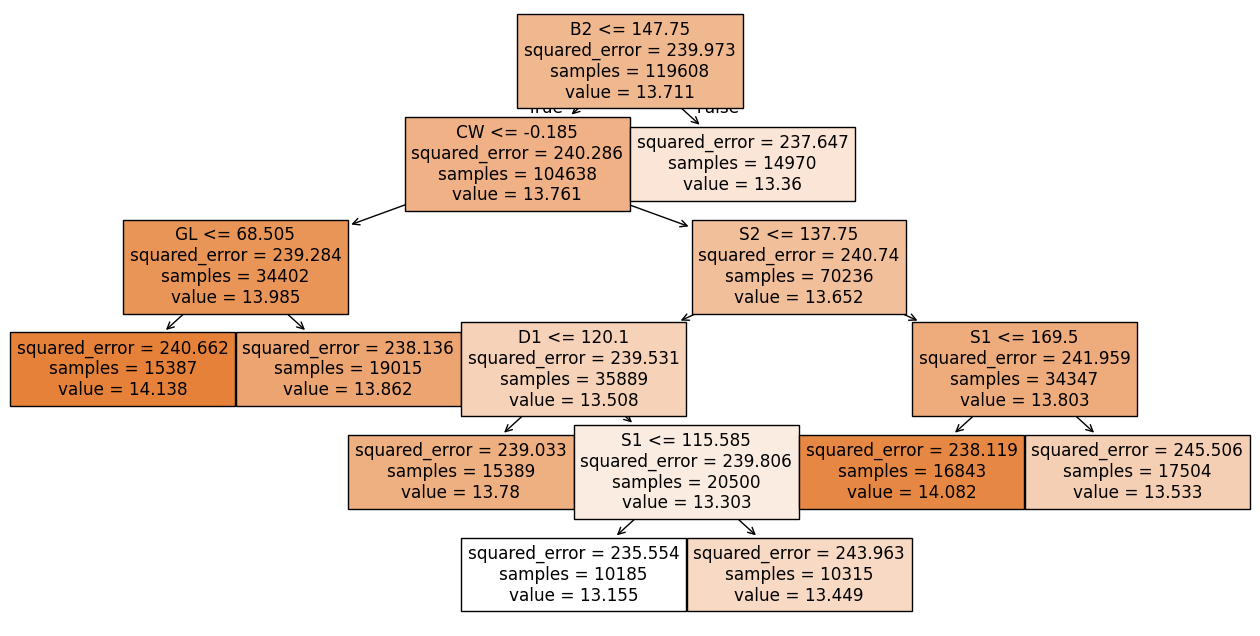

In [ ]:
plt.figure(figsize=(16,8))
sklearn.tree.plot_tree(model, feature_names=['bias', 'Sex', 'W', 'Ttl', 'DBC', 'Age', 'S1', 'S2', 'S3', 'BS', 'B1', 'B2', 'B3', 'BB', 'D1', 'D2', 'D3', 'BD', 'GL', 'CW'], filled=True)
plt.show()

'''
bias
Sex
W = init weight
ttl = init total
dbc = days between competitions
age
s1 = squat 1
s2 = squat 2
s3 = squat 3
bs = best squat
b1 = bench 1
b2 = bench 2
b3 = bench 3
bb = best bench
d1 = deadlift 1
d2 = deadlift 2
d3 = deadlift 3
bd = best deadlift
gl = Goodluck score (used to calculate how good an athlete is, compared to al other athletes)
cw = change weight
'''


## Random Forest

The Random Forest model is a giant group of decision trees, averaging their outputs. Then, their MSE and MAE scores are calculated.

The first block loads the data, as well as importing the randomforestregressor from sklearn, and joblib which deals with saving the model. Joblib will be talked about in the third block.

The second block is the hyperparameter testing block. Again, I used Randomized Search CV to save some time, as well as making the number of jobs equal to the number of cpu cores available. This code takes an incredibly long amount of time, and I usually just let it run overnight, so I do not recommend running it. If you really wanted to though, I would reduce the number of iterations (n_iter) substancially and decreased cv to 3, so that it runs a lot faster. Even with all of this, I do not recommend running this block from start to finish, it just takes too much time.

The third block uses joblib to see if a model exists and call it. I saved the model here because training the best hyperparameters took over a minute, while calling it from the file takes less than a second. If you want to see if it works correctly, simply delete random_forest_model.pkl from the current directory and run it again, it will train a new model and save it with that name. Finally, it outputs its MSE and MAE.

MSE: 239.6552, L1: 12.6896

In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float).ravel()
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

Skip this block to save hours on hyperparameter tuning

In [ ]:
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': range(1, 25),
    'min_samples_leaf': [1, 100, 1000, 5000, 10000]
}

grid_search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, n_iter=100, verbose=2)
grid_search.fit(Inputs_Train, Outputs_Train)

results = grid_search.cv_results_
sorted_indices = np.argsort(results['mean_test_score'])[::-1]  
top_5_indices = sorted_indices[:20]

print("\nTop 5 Hyperparameter Configurations and their L1 Scores:")
for rank, idx in enumerate(top_5_indices, start=1):
    params = results['params'][idx]
    l1_score = -results['mean_test_score'][idx]  
    print(f"{rank}: Hyperparameters: {params}, L1 Score: {l1_score:.4f}")


print(f"\nBest Hyperparameters: {grid_search.best_params_}")

This block gets the model from the file. If you want to run it during training yourself, delete random_forest_model.pkl from the current directory 

In [ ]:
model_filename = "random_forest_model.pkl"
if os.path.exists(model_filename):
    print("Loading existing model...")
    model = joblib.load(model_filename)
else:
    model = RandomForestRegressor(n_estimators=200, max_depth=21, min_samples_leaf=1000)
    model.fit(Inputs_Train, Outputs_Train)
    
    joblib.dump(model, model_filename)
    print("Model saved.")

y_pred = model.predict(Inputs_Test)

mse = mean_squared_error(Outputs_Test, y_pred)
mae = mean_absolute_error(Outputs_Test, y_pred)  
print(f"\nMSE: {mse:.4f}, L1: {mae:.4f}")

Loading existing model...

MSE: 239.6552, L1: 12.6896


## XGBoost-Huber

XGBoost is a type of gradient boosting algorithm based on gradient boosting decision trees. Gradient boosting decision trees are a type of model that tries to train a decision tree based on its performance, getting better after each epoch, similarly to a neural network. 

Here's how gradient boosted decision trees work. They are composed of two types of models: strong and weak models. Weak models are independednt decision trees, while strong models are multiple weak models (similar to a forest). Iteritavely, the weak model predicts the error of the strong model. Then, an alorithm is used to find the next strong model:

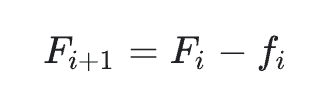

Here, $F_i$ is the strong model at step i and $f_i$ is the weak model at step i

Slowly, this model approaches the best solution for the training data.

XBGoost is essentially this algorithm going crazy. Instead of processing everything sequentially, it goes through each feature in parrallel, reducing training time by as long as the number of features you have. It has other benefits over normal gradient boosting, such as regularization, sparsity awareness (knowing and skipping zero values).

Huber is a specification for the objective function. It acts as a combination of MAE and MSE. When the error is small, it decides to treat the value as MSE does, and essentially keeps it small. Otherwise it is large, and it treats the error as MAE does. Underneath is the formula:

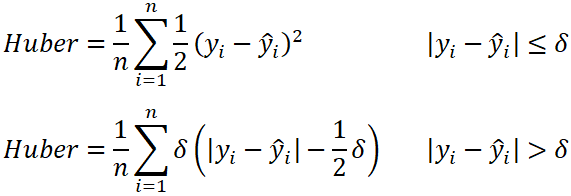

Huber helps resist outliers and allows for better generalization. Originally it worked very well before I implemented the Isolation Forest Unsupervised Learning algorithm, but it helps just as much now.

references:

https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt

https://www.ibm.com/think/topics/xgboost


MSE: 240.7804, L1: 12.6460


In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500, 700],  
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],  
    'max_depth': [3, 6, 9, 12, 15]
}
grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:pseudohubererror'), param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(Inputs_Train, Outputs_Train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
model = grid_search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3, objective='reg:pseudohubererror')

In [ ]:
model.fit(Inputs_Train, Outputs_Train)

y_pred = model.predict(Inputs_Test)

mse = mean_squared_error(Outputs_Test, y_pred)
mae = mean_absolute_error(Outputs_Test, y_pred)  
print(f"\nMSE: {mse:.4f}, L1: {mae:.4f}")


MSE: 240.7804, L1: 12.6460


## LightGBM

LightGBM (Gradient Boosting Model) is a ML model that is again based on gradient boosting decision trees. Since I already went over gradient boosting decision trees in the previous section, I will now explain some key points to LightGBM, without diving into gradient boosting decision trees again.

First, LightGBM pushes all the features into independent bins. Usually, it will push them into 256 bins, rounding floats to integers. This leads to massive speadups in the algorithm, since any decision at any level only has to compare between 256 values, instead of possibly hundreds or thousands of values. The key to this splitting is ensuring each bin has the same number of data points. This is called quantile binning. These bins are represented by integers, which takes up much less storage (1 byte for int vs 8 bytes for float), and speeds up computing on the cpu (or gpu).

Then, LightGBM will only split leafs the highest loss, meaning you can get lower loss with a fewer number of trees. Additionally, this highest loss comes from the data that represents the largest current gradients, which is tracked by the model. When the split occurs, it will sample all of the bins with high gradients and only some randomly with low gradients, which again increases speed and decreases storage of the algorithm. 

As well, it tries to bundle features together when possible, which again increases speed and storage of the model. This is called Exclusive Feature Bundling. This doesn't really work in my model though, because this is useful mostly with models with many zero values in their features.

In the following code blocks, I import the data, test for the best hyperparameters, and train the best one to find the MAE and MSE.

reference:

https://lightgbm.readthedocs.io/en/stable/Features.html#optimization-in-speed-and-memory-usage

MSE: 239.8950, L1: 12.6895

In [ ]:
Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

For the following code block, you don't have to run it. But, it shouldn't take too long, so you can if you'd like (it took less than 8 minutes on my Macbook m2)

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500, 700],  
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],  
    'max_depth': [3, 6, 9, 12, 15]

}
grid_search = GridSearchCV(lgb.LGBMRegressor(objective='regression', metric='mae'), param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search.fit(Inputs_Train, Outputs_Train)
print(f"Best Hyperparameters: {grid_search.best_params_}")
model = grid_search.best_estimator_

In [ ]:
model = lgb.LGBMRegressor(objective='regression', metric='mae', n_estimators=700, learning_rate=0.001, max_depth=3)
model.fit(Inputs_Train, Outputs_Train)

y_pred = model.predict(Inputs_Test)

mse = mean_squared_error(Outputs_Test, y_pred)
mae = mean_absolute_error(Outputs_Test, y_pred)  
print(f"\nMSE: {mse:.4f}, L1: {mae:.4f}")

## Tabnet

Tabnet is a machine learning model proposed by Google in 2019. It combines some of the best features from some of the other models in this project, and adds a transformer to pay specific attention to features at each step. Here is how it works:

Its use of attention is very similar to how decision trees work. Instead of how transformers use attention, which is by trying to find the relationship between nearby words (or tokens), it selects different features (not all of them), to develop the model, similarly to how a decision tree will select the best split option between all of the available inputs. At the end, the attention in a Tabnet model is based on which ones deliver the best result, aka the lowest loss.

Tabnets are also heavily based on Neural Networks. They use backpropogation, and non linear transformations (specifically Relu) at each step.

Otherwise, it also takes a lot from transformers. As discussed previously, it uses attention, which is originally from transformers, inside each step. While it is a different type of attention, it is more specific for tabular data.

Here is how it works:

![TabNet Explained](./tabnet_explained.png)

First, all of the data enters the encoder and is passed to the feature transformer. The feature transformer is essentially a neural network, with a batch norm, relu activation, and some fully connected layers. The output of the neural network is used to try and figure out which features are important, and should be focused on in the attentive transformer.

Then, the attention starts. The attentive transformer selects which input features to highlight, making the mask be values between 0 and 1 (rarely exactly, but inclusive), and effectively gives a certain amount of attention to specific features. 

Finally, these are repeated for a number of specified steps (a hyperparameter). The data from the attentive transformer is passed to the neural network, then back to the attentive transformer, then back to the neural network... And the encoding of the Tabnet model is complete.

Next, the data is decoded. Each of the steps in the encoder produce an individual output, which is averaged together and put through a final neural network. This neural network gets the most amount of information, and influences the next epoch the most.


In the paper linked below, the creators of the model test its performace on multiple datasets. It was consistently able to outperform other models, some seen above such as XGBoost and LightGBM. When tested on Poker Hand induction dataset, it got an accuracy of 99.2%, almost 30% better than second places XGBoost model (it should be noted a rule based approach beat out the Tabnet model though). 

In conclusion, this model is one of the best currently available for tabular data. Let's see if it performs the best on this dataset!

Here is the original tabnet paper, located from GeeksForGeeks website:

https://arxiv.org/pdf/1908.07442




In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
warnings.filterwarnings("ignore", message="Device used : mps")
warnings.filterwarnings("ignore", category=FutureWarning, module="pytorch_tabnet")

Inputs_Train = np.load('Inputs_Train.npy').astype(float)
Outputs_Train = np.load('Outputs_Train.npy').astype(float)
Inputs_Test = np.load('Inputs_Test.npy').astype(float)
Outputs_Test = np.load('Outputs_Test.npy').astype(float)

Outputs_Train = Outputs_Train.reshape(-1, 1)
Outputs_Test = Outputs_Test.reshape(-1, 1)

# Take 10% of the data for validation
Inputs_Validation = np.array(Inputs_Train[int(len(Inputs_Train) * 0.85):], dtype=np.float32)
Outputs_Validation = np.array(Outputs_Train[int(len(Outputs_Train) * 0.85):], dtype=np.float32)
Inputs_Train = np.array(Inputs_Train[:int(len(Inputs_Train) * 0.85)], dtype=np.float32)
Outputs_Train = np.array(Outputs_Train[:int(len(Outputs_Train) * 0.85)], dtype=np.float32)
Inputs_Test = np.array(Inputs_Test, dtype=np.float32)
Outputs_Test = np.array(Outputs_Test, dtype=np.float32)

standardized = Standard(Inputs_Train, Inputs_Test, Inputs_Validation)
Inputs_Train = standardized.Inputs_Train
Inputs_Test = standardized.Inputs_Test
Inputs_Validation = standardized.Inputs_Validation

In [14]:
study_dir = '/Users/shaitroy/Docs/ipf_data/openipf-2025-03-29/optuna_studies'
os.makedirs(study_dir, exist_ok=True)
storage_path = f'sqlite:///{study_dir}/tabnet_study.db'

In [15]:
sampler = optuna.samplers.TPESampler(n_startup_trials=30)  
study = optuna.create_study(
    direction="minimize",
    storage=storage_path,
    study_name="tabnet_study1",
    sampler=sampler,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner()
)

[I 2025-04-20 00:11:13,950] Using an existing study with name 'tabnet_study1' instead of creating a new one.


In [ ]:
study = optuna.load_study(
    study_name="tabnet_study1",
    storage=storage_path,
    sampler=sampler
)

In [ ]:
def objective(trial):
    max_epochs = trial.suggest_int('max_epochs', 25, 55)
    patience = trial.suggest_int('patience', 5, 15)
    batch_size = trial.suggest_int('batch_size', 256, 512, step=64)
    virtual_batch_size = trial.suggest_int('virtual_batch_size', 32, 128, step=32)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-12, 1e-7, log=True)
    
    if batch_size % virtual_batch_size != 0:
        raise optuna.exceptions.TrialPruned()
    
    n_d = trial.suggest_int('n_d', 8, 32, step=8)
    n_a = trial.suggest_int('n_a', 8, 32, step=8)
    n_steps = trial.suggest_int('n_steps', 3, 6)
    gamma = trial.suggest_float('gamma', 1.0, 1.5)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-4, log=True)
    momentum = trial.suggest_float('momentum', 0.02, 0.3)
    
    scheduler_params = {"step_size": 10, "gamma": 0.9}
    scheduler_fn = torch.optim.lr_scheduler.StepLR

    print(f" Starting trial: max_epochs: {max_epochs}, patience: {patience}, batch_size: {batch_size}, virtual_batch_size: {virtual_batch_size}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")
    
    
    
    tabnet = TabNetRegressor(
        device_name=device.type,  
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        optimizer_params=dict(lr=learning_rate, weight_decay=weight_decay),
        scheduler_params=scheduler_params,
        scheduler_fn=scheduler_fn
    )

    tabnet.fit(
        Inputs_Train, Outputs_Train,
        eval_set=[(Inputs_Validation, Outputs_Validation)],
        eval_metric=['mae'],
        max_epochs=max_epochs,
        patience=patience,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        loss_fn=torch.nn.L1Loss(),
        drop_last=False 
    )

    preds = tabnet.predict(Inputs_Validation)
    mae = mean_absolute_error(Outputs_Validation, preds)
    
    return mae  


study.optimize(objective, n_trials=1, n_jobs=1)  

print('Best hyperparameters:', study.best_params)


In [18]:
def main():
    
    scheduler_params = {"step_size": 10, "gamma": 0.9}
    scheduler_fn = torch.optim.lr_scheduler.StepLR
    
    tabnet = TabNetRegressor(
        device_name=device.type,  
        n_d=8,
        n_a=16,
        n_steps=3,
        gamma=1.3652862175086657,
        lambda_sparse=7.943511771140668e-05,
        momentum=0.10785146066021721,
        optimizer_params=dict(lr=0.007587522421602359, weight_decay=3.2998488127472045e-08),
        scheduler_params=scheduler_params,
        scheduler_fn=scheduler_fn
    )

    model_filename = "Tabnet_model.zip"  
    if os.path.exists(model_filename):
        print("Loading existing model...")
        tabnet.load_model(model_filename)  
        
        model_params = tabnet.get_params()
        print("Model Parameters:", model_params)
    else:
        tabnet.fit(
            Inputs_Train, Outputs_Train,
            eval_set=[(Inputs_Validation, Outputs_Validation)],
            eval_metric=['mae'],
            max_epochs=49,
            patience=15,
            batch_size=256,
            virtual_batch_size=64,
            loss_fn=torch.nn.L1Loss(),
            drop_last=False 
        )

        tabnet.save_model("Tabnet_model")  # Save the TabNet model using save_model
        print("Model saved.")
        
    y_pred = tabnet.predict(Inputs_Test)

    mse = mean_squared_error(Outputs_Test, y_pred)
    mae = mean_absolute_error(Outputs_Test, y_pred)  
    print(f"\nMSE: {mse:.4f}, L1: {mae:.4f}")

if __name__ == "__main__":
    freeze_support()
    main()

epoch 0  | loss: 16.01899| val_0_mae: 12.84967041015625|  0:00:27s
epoch 1  | loss: 12.72138| val_0_mae: 12.77206039428711|  0:00:53s
epoch 2  | loss: 12.69367| val_0_mae: 12.764140129089355|  0:01:19s
epoch 3  | loss: 12.67984| val_0_mae: 12.745949745178223|  0:01:45s
epoch 4  | loss: 12.67362| val_0_mae: 12.760199546813965|  0:02:11s
epoch 5  | loss: 12.67064| val_0_mae: 12.74763011932373|  0:02:37s
epoch 6  | loss: 12.6641 | val_0_mae: 12.743940353393555|  0:03:03s
epoch 7  | loss: 12.6659 | val_0_mae: 12.736419677734375|  0:03:29s
epoch 8  | loss: 12.66632| val_0_mae: 12.739009857177734|  0:03:55s
epoch 9  | loss: 12.66556| val_0_mae: 12.7356595993042|  0:04:22s
epoch 10 | loss: 12.6656 | val_0_mae: 12.735779762268066|  0:04:47s
epoch 11 | loss: 12.65897| val_0_mae: 12.738089561462402|  0:05:13s
epoch 12 | loss: 12.65965| val_0_mae: 12.741140365600586|  0:05:39s
epoch 13 | loss: 12.65808| val_0_mae: 12.737979888916016|  0:06:04s
epoch 14 | loss: 12.6601 | val_0_mae: 12.733880043029

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at Tabnet_model.zip
Model saved.

MSE: 241.0380, L1: 12.6389


# Ranking

This ranking will be primarily focused on MAE, but MSE will be used in ties.

|Place|Name|L1|MSE|
|----|----|----|----|
|1 | NN Model 2 | 12.6358 | 241.1973|
|2|Tabnet|12.6389 | 241.0380|
|3|XGBoost-Huber| 12.6460 | 240.7804|
|4|NN Model 1| 12.6679| 240.1136|
|5|LightGBM| 12.6895| 239.8950|
|6|Random Forest| 12.6896| 239.6552|
|7|Decision Tree| 12.6897| 239.7196|
|8|Linear Regression| 12.7659| 242.1831|
|9|Polynomial Regression| 12.7669| 242.2111 |




NN Model 2:

Reasoning/Thoughts:

Unsurprisngly, the best models are the decision tree ones, which tend to work extremely well with tabular data.

It is very surprising that Tabnet isn't the best performing model, since it seems to take features from all of the other top models. That being said, it still performs extremely well.

Linear regression getting a better score and ranking than Polynomial regression makes sense since the linear regression is the direct solution, while polynomial is just the gradient descent version of the linear regression model (power = 1).

Overall, this model does seem to mostly conform to some sort of line, especially considering Linear regression is only about 0.1 off from the best MAE. But, I'm still happy I made these models.

The next step for this project, which I will be doing over the summer outside of this class, are two different ideas. The first, is to change this project into a Recurrent Neural Network, even with the limited data. Then, I would like to make it a combination of Recurrent Neural Network and Multi Output Neural Network. The idea is that I want to be able to predict how an athelete progresses over time, on each individual lift (Squat, Bench, Deadlift). 



## Conclusion

In conclusion, these models can predict how well powerlifting athletes will perform when they want to change their weight for a future competition. While there is a dip in the mae and mse between the Linear regression models and the other ones, I do not believe it is significant enough to say that this data is not linearly sepearable. I am unable to provide a direct conclusion for all athletes, saying that losing weight or gaining weight is the best option, because it is inherently variable to how much the athlete weighs. But, these models can give an athlete an estimate for how well they can perform at any given body weight, so that the athlete can make their own descisions for their ideal body weight at competition.

Have a good summer!